In [7]:
import re
import functools
import operator
import itertools
import collections

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

reduce = functools.reduce

Part = collections.namedtuple('Part', ['x', 'm', 'a', 's'])

In [8]:
def read_input(filename):
    lines = []
    with open(filename) as f:
        for line in f:
            if len(line.strip()) == 0:
                yield lines
                lines = []
            else:
                lines.append(line.strip())
        yield lines

In [9]:
raw_workflows, raw_parts = read_input("../input/day19-sample1.txt")
# raw_workflows, raw_parts = read_input("../input/day19-input.txt")

In [10]:
def parse_part(p):
    return Part(*map(int, re.findall(r"\d+", p)))


In [11]:
def true(a, b):
    return True

operators = {
    '<': operator.lt,
    '>': operator.gt,
    '.': true
}

def parse_workflow(workflow):
    name, raw_rules = re.match("([a-z]+)\{(.+)\}", workflow).groups()
    rules = []
    for rule in raw_rules.split(","):
        if ":" in rule:
            condition, target = rule.split(":")
            var, op, raw_val = re.match("([xmas])([<>])(\d+)", condition).groups()
            val = int(raw_val)
        else:
            var = 'x'
            op = '.'
            val = 0
            target = rule
        rules.append(((op, var, val), target))
    return name, rules

In [12]:
parts = [parse_part(p) for p in raw_parts]
workflows = dict(parse_workflow(w) for w in raw_workflows)

In [13]:
def run_workflow(part, workflow):
    # print(part, workflow)
    # print("---")
    for rule in workflow:
        # print(rule)
        (op, var, val), target = rule
        f = operators[op]
        if f(getattr(part, var), val):
            return target

In [14]:
def sort_part(part, workflows):
    label = 'in'
    while label not in ['A', 'R']:
        w = workflows[label]
        label = run_workflow(part, w)
    return label

def sort_parts(parts, workflows):
    A = []
    R = []
    for part in parts:
        target = sort_part(part, workflows)
        if target == 'A':
            A.append(part)
        else:
            R.append(part)
    return A, R

In [15]:
X = zip(*[sort_part(p, workflows) for p in parts])
# print(list(X))

In [16]:
def sum_part(p):
    return p.x + p.m + p.a + p.s

In [17]:
part1 = sum(
    sum_part(p)
    for p in parts
    if sort_part(p, workflows) == 'A'
)
part1

19114

In [18]:
def scan(f, init, arr):
    yield init
    acc = init
    for x in arr:
        acc = f(acc, x)
        yield acc

In [19]:
[workflows['in'][:i + 1] for i in range(len(workflows['in']))]

[[(('<', 's', 1351), 'px')],
 [(('<', 's', 1351), 'px'), (('.', 'x', 0), 'qqz')]]

In [20]:
# fuck it, it's lisp time!

workflow_rules = dict()

for label, workflow in workflows.items():
    workflow_rules[label] = dict(zip(
        [w[1] for w in workflow], 
        (
            [
                list(w[0])
                for w in workflow[:1]
            ] +
            [
                ['and', *(
                     [
                         ['not', list(w[0])]
                         for w in workflow[:i]
                     ] +
                     [
                         list(w[0])
                         for w in [workflow[i]]
                     ]
                )]
                for i in range(1, len(workflow))
            ]
        )
    ))
workflow_rules

{'px': {'qkq': ['<', 'a', 2006],
  'A': ['and', ['not', ['<', 'a', 2006]], ['>', 'm', 2090]],
  'rfg': ['and',
   ['not', ['<', 'a', 2006]],
   ['not', ['>', 'm', 2090]],
   ['.', 'x', 0]]},
 'pv': {'R': ['>', 'a', 1716],
  'A': ['and', ['not', ['>', 'a', 1716]], ['.', 'x', 0]]},
 'lnx': {'A': ['and', ['not', ['>', 'm', 1548]], ['.', 'x', 0]]},
 'rfg': {'gd': ['<', 's', 537],
  'R': ['and', ['not', ['<', 's', 537]], ['>', 'x', 2440]],
  'A': ['and',
   ['not', ['<', 's', 537]],
   ['not', ['>', 'x', 2440]],
   ['.', 'x', 0]]},
 'qs': {'A': ['>', 's', 3448],
  'lnx': ['and', ['not', ['>', 's', 3448]], ['.', 'x', 0]]},
 'qkq': {'A': ['<', 'x', 1416],
  'crn': ['and', ['not', ['<', 'x', 1416]], ['.', 'x', 0]]},
 'crn': {'A': ['>', 'x', 2662],
  'R': ['and', ['not', ['>', 'x', 2662]], ['.', 'x', 0]]},
 'in': {'px': ['<', 's', 1351],
  'qqz': ['and', ['not', ['<', 's', 1351]], ['.', 'x', 0]]},
 'qqz': {'qs': ['>', 's', 2770],
  'hdj': ['and', ['not', ['>', 's', 2770]], ['<', 'm', 1801]],
  

In [21]:
# graph between workflows
G = nx.DiGraph()
G.add_nodes_from(workflows.keys())
G.add_node('A')
G.add_node('R')

In [22]:
G.add_edges_from([
    (k, tar)
    for k, v in workflows.items()
    for _, tar in v
])

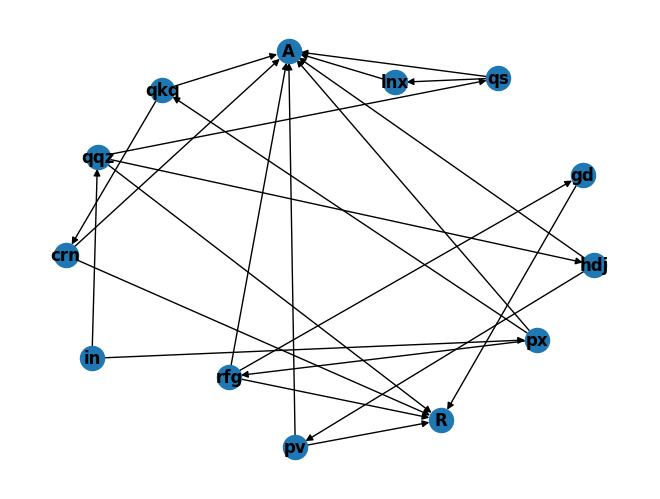

In [23]:
nx.draw(G, pos=nx.spring_layout(G, k=3), with_labels=True, font_weight='bold')

In [24]:
path_rules = []
for path in nx.all_simple_paths(G, source='in', target='A'):
    path_rules.append(['and', *list(workflow_rules[a][b] for a, b in itertools.pairwise(path))])

giant_lispy_rule = ['or', *path_rules]

giant_lispy_rule

['or',
 ['and', ['<', 's', 1351], ['<', 'a', 2006], ['<', 'x', 1416]],
 ['and',
  ['<', 's', 1351],
  ['<', 'a', 2006],
  ['and', ['not', ['<', 'x', 1416]], ['.', 'x', 0]],
  ['>', 'x', 2662]],
 ['and',
  ['<', 's', 1351],
  ['and', ['not', ['<', 'a', 2006]], ['>', 'm', 2090]]],
 ['and',
  ['<', 's', 1351],
  ['and', ['not', ['<', 'a', 2006]], ['not', ['>', 'm', 2090]], ['.', 'x', 0]],
  ['and', ['not', ['<', 's', 537]], ['not', ['>', 'x', 2440]], ['.', 'x', 0]]],
 ['and',
  ['and', ['not', ['<', 's', 1351]], ['.', 'x', 0]],
  ['>', 's', 2770],
  ['>', 's', 3448]],
 ['and',
  ['and', ['not', ['<', 's', 1351]], ['.', 'x', 0]],
  ['>', 's', 2770],
  ['and', ['not', ['>', 's', 3448]], ['.', 'x', 0]],
  ['and', ['not', ['>', 'm', 1548]], ['.', 'x', 0]]],
 ['and',
  ['and', ['not', ['<', 's', 1351]], ['.', 'x', 0]],
  ['and', ['not', ['>', 's', 2770]], ['<', 'm', 1801]],
  ['>', 'm', 838]],
 ['and',
  ['and', ['not', ['<', 's', 1351]], ['.', 'x', 0]],
  ['and', ['not', ['>', 's', 2770]], ['

In [33]:
# aside: logic on lists of intervals


# def reduce2(f, iterable):
#     it = iter(iterable)
#     value = [next(it)]
#     for element in it:
#         value = [vv for v in value for vv in f(v, element)]
#     return value

def overlap(a, b):
    return a[1] >= b[0] and b[1] >= b[0]


def subinterval(a, b):
    return a[0] >= b[0] and a[1] <= b[1]


def filter_empty(aa):
    return [a for a in aa if a[0] < a[1]]


def merge2(aa, bb):
    result = sorted(aa + bb)
    changed = True
    
    result = filter_empty(result)
    
    while changed:
        changed = False
        new_result = set()
        
        for a, b in itertools.pairwise(result):
            if overlap(a, b):
                new_result.add((min(a[0], b[0]), max(a[1], b[1])))
                changed = True
            else:
                new_result.add(a)
                new_result.add(b)
        if changed:
            result = sorted(new_result)
    return result


def merge_many(intvs):
    return reduce(merge2, intvs)


def intersect2(aa, bb):
    result = []
    for (a, b) in itertools.product(aa, bb):
        if overlap(a, b):
            result.append((max(a[0], b[0]), min([a[1], b[1]])))
    return sorted(result)


def intersect_many(intvs):
    return reduce(intersect2, intvs)


def complement1(aa):
    if len(aa) == 0:
        return [(0, 10000)]
    else:
        result = []
        if aa[0][0] > 0:
            result.append((0, aa[0][0] - 1))
        for a,b in itertools.pairwise(aa):
            result.append((a[1] + 1, b[0] - 1))
        if aa[-1][1] < 10000:
            result.append((aa[-1][1] + 1, 10000))
        return result


def complement_many(intvs):
    xx = list(intvs)
    return merge_many(complement1(a) for a in xx)



In [34]:
# intersect2([(1, 9), (10, 20)], [(5, 15)])

In [35]:
# merge2([(1, 9), (10, 11)], [(5, 15)])

In [36]:
list(zip([1, 2][:-1], [1, 2][1:]))

[(1, 2)]

In [37]:
# functions i need to implement:
# - or
# - and
# - not
# - <
# - >
# - . (true)

# need to work on lists of intervals for 'or' and 'not' to work
symbols = {
    'x': [(1, 4000)],
    'm': [(1, 4000)],
    'a': [(1, 4000)],
    's': [(1, 4000)]
}



def eval_expr(expr):
    fn = expr[0]
    args = expr[1:]
    if fn == 's': # already evaluated xmas table
        return args
    elif fn == '<':
        return fn_lt(args, symbols)
    elif fn == '>':
        return fn_gt(args, symbols)
    elif fn == '.':
        return fn_true(args, symbols)
    elif fn == 'and':
        return fn_and(args)
    elif fn == 'or':
        return fn_or(args)
    elif fn == 'not':
        return fn_not(args)
    else:
        raise Exception('invalid function call', expr)



# always expr = [symbol, val]
def fn_lt(expr, symbols):
    symbol, val = expr
    aa = symbols[symbol]
    s2 = symbols.copy()
    s2[symbol] = intersect2(aa, [(0, val - 1)])
    return ['s', s2]


def fn_gt(expr, symbols):
    symbol, val = expr
    aa = symbols[symbol]
    s2 = symbols.copy()
    s2[symbol] = intersect2(aa, [(val - 1, 10000)])
    return ['s', s2]


def fn_true(expr, symbols):
    s2 = symbols.copy()
    return ['s', s2]


def empty_table(tab):
    any()


def fn_and(expr):
    evaled_symbols = [eval_expr(e) for e in expr]
    
    
    
    return {
        k: intersect_many(e[k] for e in evalled_symbols)
        for k in symbols.keys()
    }


def fn_or(expr):
    evalled_symbols = [eval_expr(e) for e in expr]
    return {
        k: merge_many(e[k] for e in evalled_symbols)
        for k in symbols.keys()
    }


def fn_not(expr):
    evalled_symbols = [eval_expr(e) for e in expr]
    return {
        k: complement_many(e[k] for e in evalled_symbols)
        for k in symbols.keys()
    }

In [43]:
import pprint
pp = pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)
pp.pprint(eval_expr(giant_lispy_rule))

{   'x': [(1, 1415), (2661, 4000)],
    'm': [(1, 4000)],
    'a': [(1, 2005), (2006, 4000)],
    's': [(1, 1350), (1351, 2768), (3447, 4000)]}


In [44]:
for rule in giant_lispy_rule[1:]:
    pp.pprint(eval_expr(rule))

{'x': [(1, 1415)], 'm': [(1, 4000)], 'a': [(1, 2005)], 's': [(1, 1350)]}
{'x': [(2661, 4000)], 'm': [], 'a': [], 's': []}
{'x': [], 'm': [], 'a': [(2006, 4000)], 's': []}
{'x': [], 'm': [], 'a': [], 's': []}
{   'x': [(4001, 4000)],
    'm': [(4001, 4000)],
    'a': [(4001, 4000)],
    's': [(3447, 4000)]}
{'x': [], 'm': [], 'a': [], 's': []}
{'x': [], 'm': [], 'a': [], 's': [(1351, 2768)]}
{'x': [], 'm': [], 'a': [], 's': []}


In [46]:
167409079868000 / 4000 / 4000 / 4000

2615.7668729375

In [61]:
ranges = eval_expr(giant_lispy_rule)

def part_accepted(part):
    accepted = True
    for k in ['x', 'm', 'a', 's']:
        x = getattr(p, k)
        accepted = accepted and any(x >= lo and x <= hi for lo,hi in ranges[k])
    return accepted

In [63]:
import random

for n in range(10_000):
    x = random.randint(1, 4000)
    m = random.randint(1, 4000)
    a = random.randint(1, 4000)
    s = random.randint(1, 4000)
    
    p = Part(x, m, a, s)
    
    r1 = part_accepted(p)
    r2 = sort_part(p, workflows) == 'A'
    
    if r1 != r2:
        print("wrong result", p, r1, r2)
    

wrong result Part(x=1032, m=2708, a=1909, s=1380) True False
wrong result Part(x=2411, m=709, a=2948, s=3594) False True
wrong result Part(x=2539, m=801, a=144, s=3883) False True
wrong result Part(x=2578, m=1690, a=2572, s=2226) False True
wrong result Part(x=1796, m=264, a=860, s=2371) False True
wrong result Part(x=2250, m=1732, a=2301, s=3178) False True
wrong result Part(x=1090, m=3111, a=200, s=2435) True False
wrong result Part(x=2411, m=3105, a=3958, s=2931) False True
wrong result Part(x=3203, m=1863, a=3010, s=2167) True False
wrong result Part(x=3182, m=2967, a=291, s=1691) True False
wrong result Part(x=2109, m=1051, a=3463, s=1758) False True
wrong result Part(x=2535, m=845, a=648, s=2599) False True
wrong result Part(x=753, m=2798, a=2807, s=1792) True False
wrong result Part(x=721, m=1955, a=3811, s=310) True False
wrong result Part(x=3916, m=213, a=2869, s=69) True False
wrong result Part(x=1988, m=1447, a=2311, s=1476) False True
wrong result Part(x=3006, m=3050, a=346

In [58]:
p = Part(1, 2, 3, 4)

In [60]:
getattr(p, 'x')

1